# Xarray扩展
本节课的学习目标有：  
1  内插法  
2 计算距平  
3  重采样  
4  时间序列滑窗 

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
%xmode Minimal

Exception reporting mode: Minimal


# 1 内插法  
如果我们想估计不同坐标上的数据变量的值，该怎么办？这就是内插法的作用。

In [2]:
# we write it out explicitly so we can see each point.
x_data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
f = xr.DataArray(x_data**2, dims=['x'], coords={'x': x_data})
f

<xarray.DataArray (x: 11)>
array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100])
Coordinates:
  * x        (x) int32 0 1 2 3 4 5 6 7 8 9 10

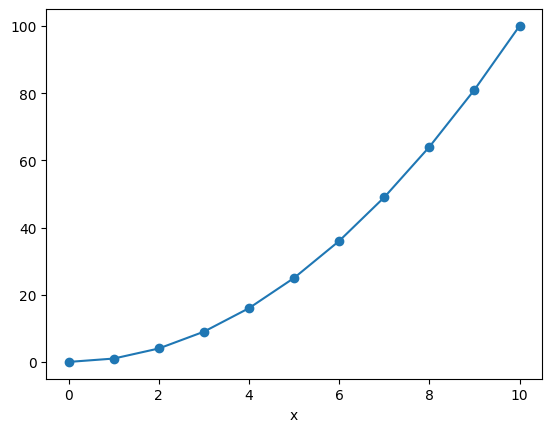

In [5]:
f.plot(marker='o')

我们只有x中的整数点的数据。但如果我们想估计比如说4.5的值呢？

In [6]:
f.sel(x=4.5)

KeyError: "not all values found in index 'x'. Try setting the `method` keyword argument (example: method='nearest')."

在这里我们就需要用到内插法啦

In [7]:
f.interp(x=4.5)

<xarray.DataArray ()>
array(20.5)
Coordinates:
    x        float64 4.5

内插法在有不同的插值模式。比如：线性插值，最邻近插值，三次样条函数插值

In [6]:
# default 线性插值
f.interp(x=4.5, method='linear').values

array(20.5)

In [7]:
# 最邻近插值
f.interp(x=4.5, method='nearest').values

array(16.)

In [8]:
#三次样条插值
f.interp(x=4.5, method='cubic').values

array(20.25)

我们可以一次插值到一个全新的坐标。

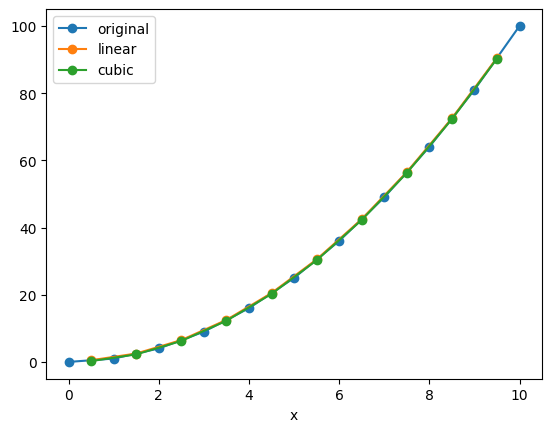

In [8]:
x_new = x_data + 0.5
f_interp_linear = f.interp(x=x_new, method='linear')
f_interp_cubic = f.interp(x=x_new, method='cubic')
f.plot(marker='o', label='original')
f_interp_linear.plot(marker='o', label='linear')
f_interp_cubic.plot(marker='o', label='cubic')
plt.legend()

请注意，不支持原始范围以外的数值。

下面这段代码其中，f_interp_linear表示使用线性插值法后的结果，values表示返回插值后的值。

In [9]:
f_interp_linear.values

array([ 0.5,  2.5,  6.5, 12.5, 20.5, 30.5, 42.5, 56.5, 72.5, 90.5,  nan])

**注意事项**  

你可以将插值应用于任何维度，甚至一次应用于多个维度。(多维插值只支持mode='nearest' 和mode='linear'）。但是请记住，Xarray没有对地理的内置理解。如果你在lat / lon坐标上使用interp，它将只是对lat / lon值进行插值。对球面几何的更复杂的处理需要另一个软件包，如[xesmf](https://xesmf.readthedocs.io/)。

## 2 距平
现代气候学认为在相当长的时间段（一般认为是 30 年）中，变量多年平均是一个稳定的值。因此在一个时间段中，如果能够充分认识变量随平均状态的变化趋势，那么对于预测未来情况是非常有利的。那么这个所谓随着平均态的偏移值便可称为距平（异常，anomaly）.
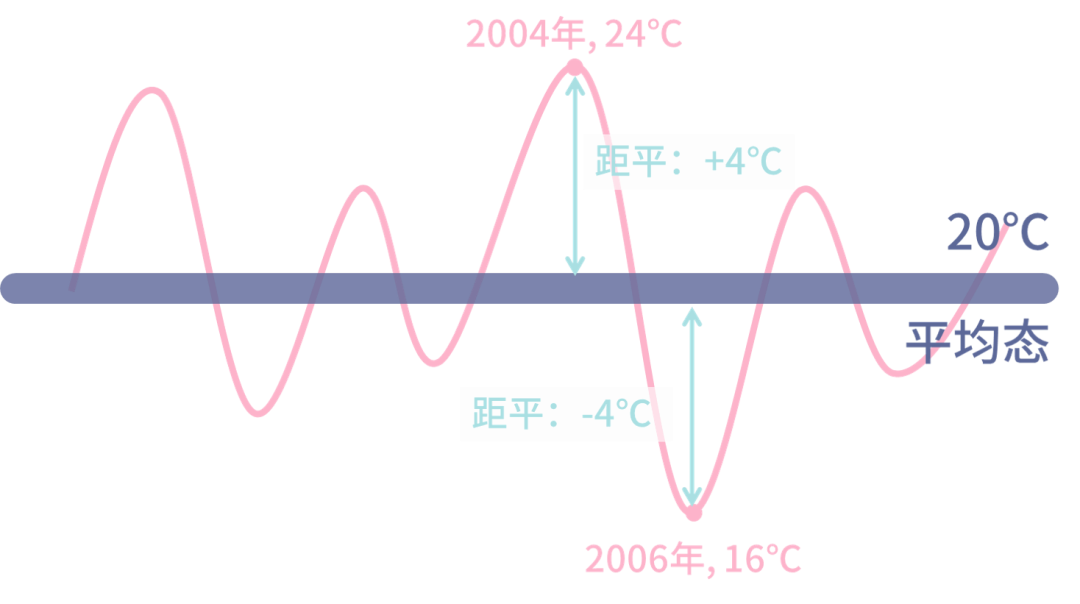


### 2.1  为什么要费尽心思研究变量的距平而非变量的原始数据？  
若针对于温度这个变量而言，即为什么要使用温度距平（偏离平均值的值）而不非研究绝对温度的变化？

出于以下几个原因，很难对全球平均表面温度以绝对温度的形式进行计算。

（1）某些地域的气象观测站点分布稀少（如撒哈拉沙漠地区、偏远的密林），这就意味着为取得格点数据（栅格数据）必须对离散的站点数据值在较大且站点分布稀疏区域内进行插值。这会带来很大的数据不真实性。

（2）对于那些山区中的数据（山区中的的气象观测大多是有人居住地区），必须考虑海拔高度对区域平均温度的影响。例如，对于一个地区的夏季而言，无论是在山顶还是山下，都可能比往年的平均温度低，然而若考虑绝对温度，这两个地方有很大的不同（一般认为山顶气温比山下温度低）。

（3）在同一时间范围内在一个更小的尺度下（即格点分辨率）考虑变量变化的基准参考值，然后基于这个基准参考值（多年平均值）计算相对于这个基准参考值的异常变化（距平）。在这种情况下，整合了数据，使得不同地域的变量能够得以进行比较，以便反映一个区域内不同地方的变量分布形式。

### 2.2 计算距平
下面需从数据集中删除气候平均，从而得到变量随气候平均态变化的残差。一般将这个残差称为距平。

对转换（Transformations）操作而言，消除数据的气候平均是一个很好的例子。转换操作对分组的对象进行操作，但不改变原数据的维度尺寸。

xarray 通过使用Groupby 算法使这些类型的转换变得容易。下面给出了计算去除月份温度差异的海温月数据。

In [3]:
path = "sst.mnmean.nc"
# 丢弃一个不必要导入的变量
ds = xr.open_dataset(path, drop_variables=["time_bnds"])
ds = ds.sel(time=slice("1960", "2018")).load()

In [8]:
def remove_time_mean(x):
    return x - x.mean(dim="time")

ds_anom = ds.groupby("time.month").map(remove_time_mean)
ds_anom

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 9.537e-07 9.537e-07 9.537e-07 ... nan nan

也可以简写为下面这种形式

gb是分好月份后的海温数据（12 组），gb.mean(dim="time")是各月的平均海温（12 组）   
那么gb - gb.mean(dim="time")即为对 12 组中的对应组的海温数据（这个组内的每一天的海温数据）减去平均的海温数据。这个结果即为距平。

当经过上述去除季节性周期的影响后，便很容易发现气候变率的信号。

In [36]:
gb = ds.groupby("time.month")
ds_anom = gb - gb.mean(dim="time")
ds_anom

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 9.537e-07 9.537e-07 9.537e-07 ... nan nan

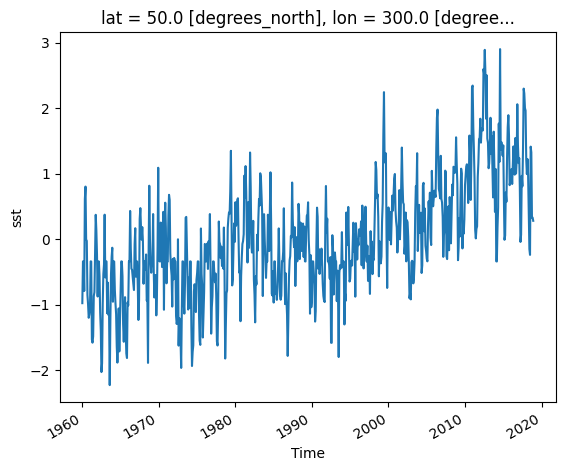

In [37]:
#北大西洋单点的时间序列
ds_anom.sst.sel(lon=300, lat=50).plot()

北大西洋单点的时间序列  
2018 年 1 月 1 日与 1960 年 1 月 1 日之间 SST 之间的差异

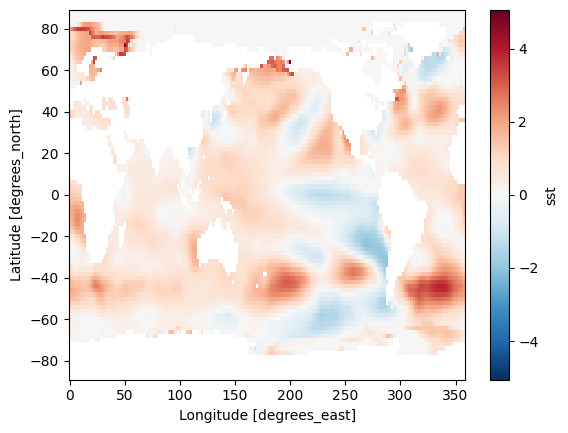

In [10]:
(ds_anom.sel(time="2018-01-01") - ds_anom.sel(time="1960-01-01")).sst.plot()

## 3  Resample（重采样）
xarray 中的Resample（重采样）的处理方法与 Pandas 包几乎相同。就本质而言，Resample 也是一个分割数据的操作。它与分割操作的基本语法类似。  
**应当注意，对于 Resample 操作而言，其作用对象必须是时间维度。**

为说明 Resample 的用法，下面给出一个例子计算逐五年的平均值曲线。

In [16]:
resample_obj = ds_anom.resample(time="5Y")
resample_obj

{numpy.datetime64('1960-12-31T00:00:00.000000000'): slice(0, 12, None), numpy.datetime64('1965-12-31T00:00:00.000000000'): slice(12, 72, None), numpy.datetime64('1970-12-31T00:00:00.000000000'): slice(72, 132, None), numpy.datetime64('1975-12-31T00:00:00.000000000'): slice(132, 192, None), numpy.datetime64('1980-12-31T00:00:00.000000000'): slice(192, 252, None), numpy.datetime64('1985-12-31T00:00:00.000000000'): slice(252, 312, None), numpy.datetime64('1990-12-31T00:00:00.000000000'): slice(312, 372, None), numpy.datetime64('1995-12-31T00:00:00.000000000'): slice(372, 432, None), numpy.datetime64('2000-12-31T00:00:00.000000000'): slice(432, 492, None), numpy.datetime64('2005-12-31T00:00:00.000000000'): slice(492, 552, None), numpy.datetime64('2010-12-31T00:00:00.000000000'): slice(552, 612, None), numpy.datetime64('2015-12-31T00:00:00.000000000'): slice(612, 672, None), numpy.datetime64('2020-12-31T00:00:00.000000000'): slice(672, None, None)}


可以看到对于 Resample 操作而言，与 Groupby 操作非常类似，首先也创建了一个DatasetResample对象。.resample(time="5Y")是对如何对时间进行重采样进行设置，维度为time，设置的时间间隔为 5 年。应当指出这里的时间间隔写法与之前pd.date_range函数中的freq的时间间隔的关键词是一致的。

In [20]:
ds_anom_resample = resample_obj.mean(dim="time")
ds_anom_resample

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 13)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-12-31 1965-12-31 ... 2020-12-31
Data variables:
    sst      (time, lat, lon) float32 -0.0005696 -0.0005512 ... nan nan

之后需要对这些分割好的 Resample 对象进行取平均，以便获得每一个分组好的 Resample 对象中的平均值。

假如第一个 Resample 对象的时间范围为 2010 年-2014 年，那么需要对这五年进行平均后，以便得到第一个进行重采样后的值。往后的时间范围类似。

为了说明进行重采样后的效果，下面来看一下(50°N, 60°E)的海温变化情况

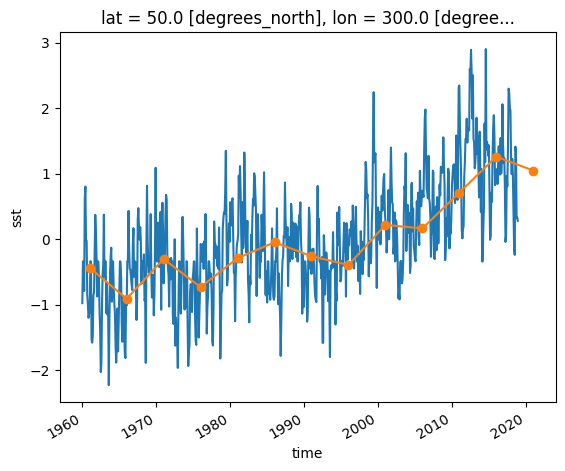

In [46]:
#第一行代码将原始海温变化的时间序列画了出来，第二行画了经逐 5 年平均后的海温变化的时间序列。
ds_anom.sst.sel(lon=300, lat=50).plot()
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker="o")

注：上面的代码中  
.plot(marker="o")中的参数marker="o"指定了点的记号类型。如下图是关于marker参数的可设置类型
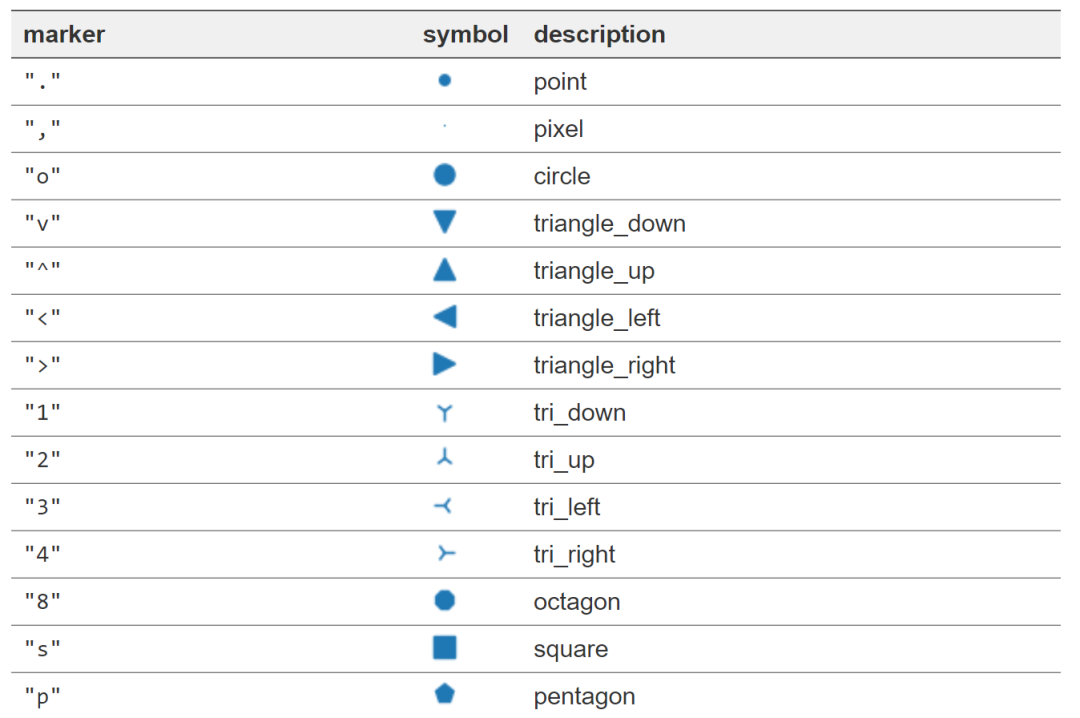

## 4  Rolling（时间窗移动）
Rolling 方法也与pandas 包中的类似，但是稍有不同的是，它可适用于任意维度。如果将其作用于时间维度，也可称之为滑动平均。

下面代码中：  
参数time=12指定了对维度time以 12 个月为周期（月数据）变动时间窗，  
center参数表明以当前窗的两侧筛选数据，否则是以当前窗的前 12 个月作为筛选目标（包括本身）。  
.mean()表明对每一个 Rolling 对象取平均。

In [6]:
ds_anom_rolling = ds_anom.rolling(time=12, center = True).mean()
ds_anom_rolling

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [5]:
#为了更好的说明 Rolling 的作用，下面举一个简单的例子说明其功能。
da = xr.DataArray(
     np.linspace(0, 11, num=12),
     dims="time",
     coords=[
     pd.date_range("1999-12-15",periods=12,freq=pd.DateOffset(months=1))
     ]
    )
da

<xarray.DataArray (time: 12)>
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])
Coordinates:
  * time     (time) datetime64[ns] 1999-12-15 2000-01-15 ... 2000-11-15

此处创建 DataArray 类型 da 的方法与之前创建 DataArray 稍有不同。np.linspace(0, 11, num=12)代表创建数组的初始值为 0，终末值为 11，并且在这个范围内均匀间隔生成 12 个样本。  
pd.date_range()函数用于生成时间序列。这个函数有很多参数可以调整，例如start和end参数可以指定日期范围，periods参数可以指定时间序列中的时间点数量。在这个例子中，我们使用了freq参数来指定时间序列中相邻时间点之间的间隔为1个月。这个代码段最后输出了da对象。

对于多个维度的创建，列表的创建方法也与之前的字典创建方法类似

In [51]:
foo = xr.DataArray(
   np.random.rand(4, 3),
   dims=("time", "space"),
   coords=[
       pd.date_range("2000-01-01", periods=4),
       ["IA", "IL", "IN"],
       ]
   )
foo

<xarray.DataArray (time: 4, space: 3)>
array([[0.98502282, 0.67221626, 0.826633  ],
       [0.14128665, 0.89804357, 0.15930859],
       [0.24741589, 0.98560751, 0.01117667],
       [0.9079976 , 0.52756882, 0.30578328]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'

多个维度dims需用小括号或者方括号包裹。不同的 coords 之间的参数用逗号间隔，因为用列表创建坐标维度的特性，无需写坐标维度名称。坐标维度的名称将沿用维度名称的名字。

**（1）首先先创建一个时间窗对象**

In [53]:
da.rolling(time=5, center=True)

DataArrayRolling [time->5(center)]

**（2）然后对这个时间窗对象施以平均的方法，即.mean()**

In [54]:
da.rolling(time=5, center=True).mean()

<xarray.DataArray (time: 12)>
array([nan, nan,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 1999-12-15 2000-01-15 ... 2000-11-15

5年滑动平均

我们可以通过下图来理解时间窗是如何操作数据的

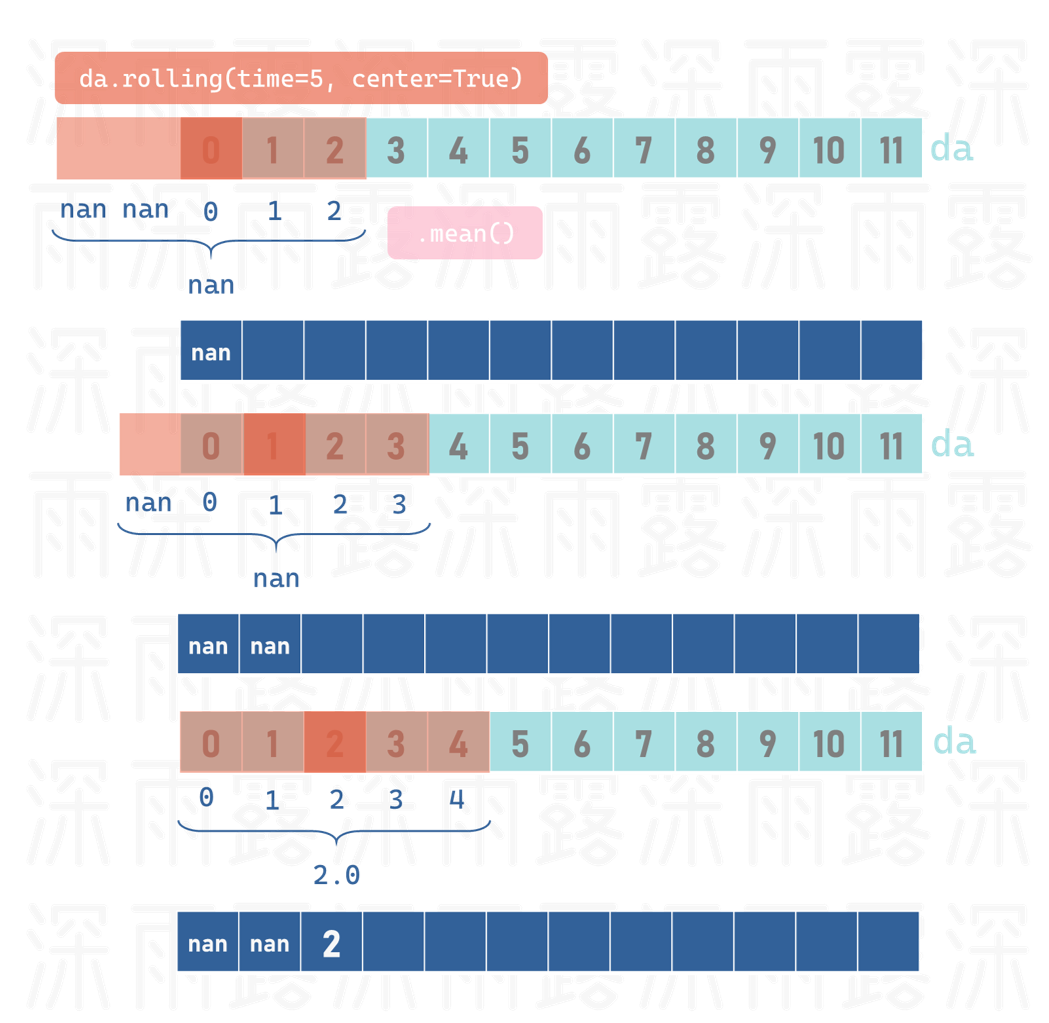

时间窗操作过程理解

若时间窗为偶数值，那么对应中心位置将会在平均位置偏右侧

In [56]:
da.rolling(time=4, center=True).mean()

<xarray.DataArray (time: 12)>
array([nan, nan, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, nan])
Coordinates:
  * time     (time) datetime64[ns] 1999-12-15 2000-01-15 ... 2000-11-15

可用下图理解上述原理

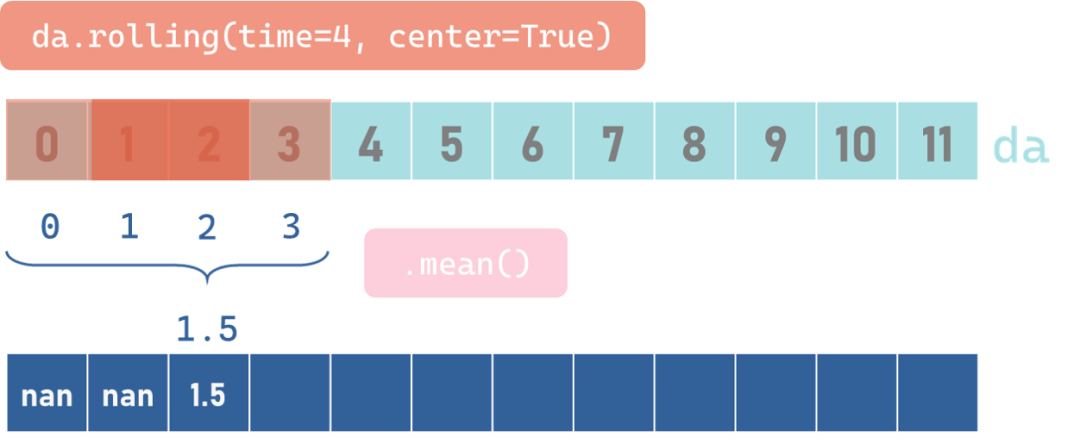

若不指定参数center=True，则采用从当前元素往上筛选的方法，否则采用以当前元素为中心，从两个方向上进行筛选。

In [57]:
da.rolling(time=5).mean()

<xarray.DataArray (time: 12)>
array([nan, nan, nan, nan,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])
Coordinates:
  * time     (time) datetime64[ns] 1999-12-15 2000-01-15 ... 2000-11-15

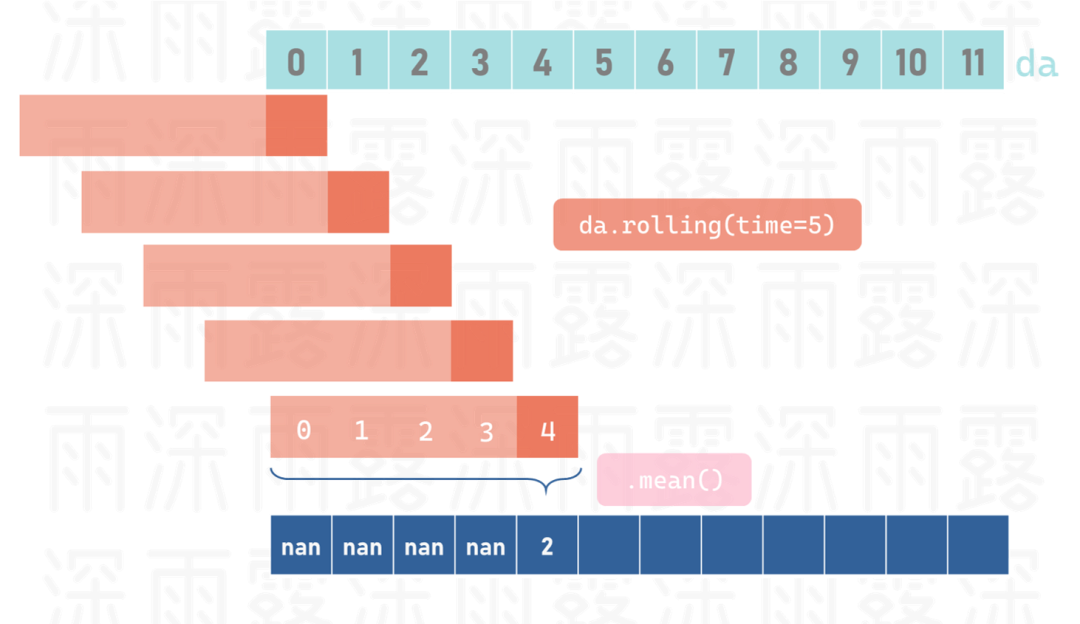

当然和 grouby 对象类似，也可用 list 来访问每一个时间窗移动对象

In [58]:
rolling_obj = da.rolling(time=5, center=True)
list(rolling_obj)[4][1]

<xarray.DataArray (time: 5)>
array([2., 3., 4., 5., 6.])
Coordinates:
  * time     (time) datetime64[ns] 2000-02-15 2000-03-15 ... 2000-06-15

## 一个高级的例子  
在这个例子中，我们将展示一个使用Xarray的实际工作流程。我们将  
* 加载一个 "未区分流域 "数据集  
* 将流域内插到我们的SST数据集的坐标上  
* 将SST按流域分组  
* 转换为Pandas数据框架，绘制各流域平均SST图

In [7]:
basin = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods')
basin

<xarray.Dataset>
Dimensions:  (X: 360, Y: 180, Z: 33)
Coordinates:
  * X        (X) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * Y        (Y) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * Z        (Z) float32 0.0 10.0 20.0 30.0 50.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Data variables:
    basin    (Z, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

In [39]:
basin = basin.rename({'X': 'lon', 'Y': 'lat'})
basin

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180, Z: 33)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * Z        (Z) float32 0.0 10.0 20.0 30.0 50.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Data variables:
    basin    (Z, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [22]:
basin_surf = basin.basin[0]
basin_surf

<xarray.DataArray 'basin' (Y: 180, X: 360)>
[64800 values with dtype=float32]
Coordinates:
  * X        (X) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * Y        (Y) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    Z        float32 0.0
Attributes:
    long_name:  basin code
    CLIST:      Atlantic Ocean\nPacific Ocean \nIndian Ocean\nMediterranean S...
    valid_min:  1
    valid_max:  58
    scale_min:  1
    units:      ids
    scale_max:  58

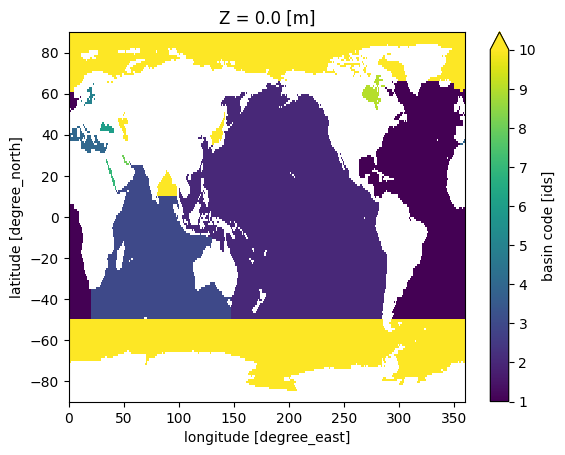

In [41]:
basin_surf.plot(vmax=10)

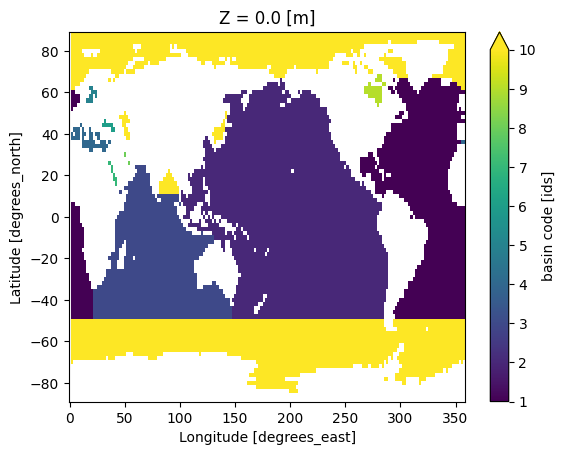

In [42]:
basin_surf_interp = basin_surf.interp_like(ds.sst, method='nearest')
basin_surf_interp.plot(vmax=10)

In [43]:
ds.sst.groupby(basin_surf_interp).first()

<xarray.DataArray 'sst' (time: 708, basin: 14)>
array([[-1.8000000e+00, -1.8000000e+00,  2.3455315e+01, ...,
        -1.8000000e+00,  3.3971915e+00,  2.4182198e+01],
       [-1.8000000e+00, -1.8000000e+00,  2.3722523e+01, ...,
        -1.8000000e+00,  3.5737813e-02,  2.4596569e+01],
       [-1.8000000e+00, -1.8000000e+00,  2.4601315e+01, ...,
        -1.8000000e+00, -2.6487017e-01,  2.6234186e+01],
       ...,
       [ 6.9998962e-01,  6.5480309e+00,  2.9293716e+01, ...,
         1.0894292e+01,  1.5965587e+01,  2.9429205e+01],
       [-7.6822066e-01,  3.1116159e+00,  2.7622252e+01, ...,
         5.3953505e+00,  1.0692620e+01,  2.7764416e+01],
       [-1.8000000e+00, -2.2021711e-02,  2.5897924e+01, ...,
         5.0381303e-01,  7.2609553e+00,  2.6171684e+01]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    Z        float32 0.0
  * basin    (basin) float64 1.0 2.0 3.0 4.0 5.0 ... 10.0 11.0 12.0 53.0 56.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [44]:
basin_mean_sst = ds.sst.groupby(basin_surf_interp).mean()
basin_mean_sst

<xarray.DataArray 'sst' (time: 708, basin: 14)>
array([[18.585493 , 20.757555 , 21.572067 , ...,  6.238062 ,  6.889794 ,
        26.49982  ],
       [18.705065 , 20.81674  , 21.902279 , ...,  4.8877654,  5.44638  ,
        26.577093 ],
       [18.845842 , 20.865038 , 22.031416 , ...,  4.686406 ,  5.5322194,
        27.908558 ],
       ...,
       [19.850618 , 21.961895 , 20.390331 , ..., 17.585295 , 18.172445 ,
        29.34034  ],
       [19.424898 , 21.724726 , 21.062313 , ..., 13.477972 , 13.858795 ,
        28.758406 ],
       [19.265835 , 21.513996 , 21.815357 , ...,  9.432378 , 10.582516 ,
        27.907026 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    Z        float32 0.0
  * basin    (basin) float64 1.0 2.0 3.0 4.0 5.0 ... 10.0 11.0 12.0 53.0 56.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [45]:
df = basin_mean_sst.mean('time').to_dataframe()
df

,Z,sst
basin,,
1.0,0.0,19.285156
2.0,0.0,21.178253
3.0,0.0,21.127140
4.0,0.0,19.845943
5.0,0.0,8.131697
6.0,0.0,15.083328
7.0,0.0,28.494251
8.0,0.0,26.618536
9.0,0.0,0.309167


In [46]:
import pandas as pd
basin_names = basin_surf.attrs['CLIST'].split('\n')
basin_df = pd.Series(basin_names, index=np.arange(1, len(basin_names)+1))
basin_df

1                 Atlantic Ocean
2                 Pacific Ocean 
3                   Indian Ocean
4              Mediterranean Sea
5                     Baltic Sea
6                      Black Sea
7                        Red Sea
8                   Persian Gulf
9                     Hudson Bay
10                Southern Ocean
11                  Arctic Ocean
12                  Sea of Japan
13                      Kara Sea
14                      Sulu Sea
15                    Baffin Bay
16            East Mediterranean
17            West Mediterranean
18                Sea of Okhotsk
19                     Banda Sea
20                 Caribbean Sea
21                 Andaman Basin
22               North Caribbean
23                Gulf of Mexico
24                  Beaufort Sea
25               South China Sea
26                   Barents Sea
27                   Celebes Sea
28                Aleutian Basin
29                    Fiji Basin
30          North American Basin
31        

In [47]:
df = df.join(basin_df.rename('basin_name'))

<Axes: xlabel='basin_name'>

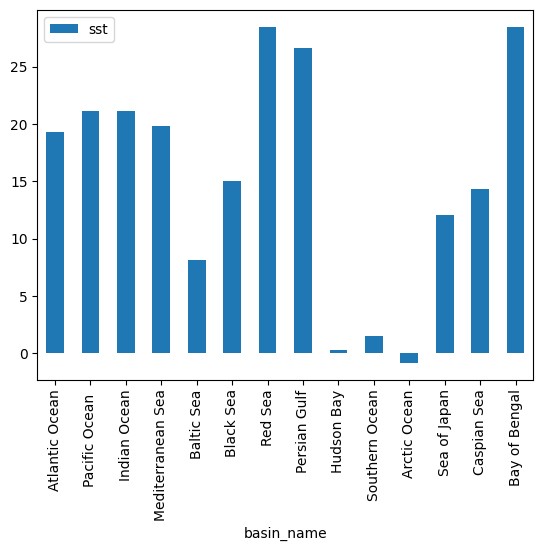

In [48]:
df.plot.bar(y='sst', x='basin_name')